In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import requests
import io
import plotly.express as px
import plotly.graph_objects as go
import datetime
import time
from datetime import date
import matplotlib.pyplot as plt
import six
import xlsxwriter


C:\Users\alisson.amaral\AppData\Local\Programs\Python\Python38\lib\site-packages\geopandas\_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
municipios = gpd.read_file('./shp/municipios_2019.shp')
UC = gpd.read_file('./shp/UCs.shp')
#UC_nan = gpd.read_file('./shp/UCs_nan.shp')

In [10]:
UC

,Dominio,GRUPO,NOME_UC,geometry
0,Estadual,Proteção Integra,PE da Serra dos Montes Altos,"MULTIPOLYGON (((-43.10969 -14.28379, -43.10967..."
1,Estadual,Proteção Integra,MN da Cachoeira do Ferro Doido,"POLYGON ((-40.98000 -11.61006, -40.99000 -11.6..."
2,Estadual,Uso Sustentável,APA do Lago do Sobradinho,"POLYGON ((-40.91637 -9.08151, -40.91041 -9.085..."
3,Estadual,Uso Sustentável,APA do Lago de Pedra do Cavalo,"POLYGON ((-38.97417 -12.27295, -38.97287 -12.2..."
4,Estadual,Uso Sustentável,APA da Ponta da Baleia/Abrolhos,"POLYGON ((-39.03332 -17.53347, -38.75000 -17.7..."
...,...,...,...,...
108,Municipal,Proteção Integral,PM Municipal de Andaraí Rota das Cachoeiras,"POLYGON ((-41.30047 -12.95945, -41.29984 -12.9..."
109,Municipal,Proteção Integral,PM das Dunas de Abrantes,"POLYGON ((-38.22913 -12.80788, -38.22696 -12.8..."
110,Municipal,Proteção Integral,PM Municipal Zabelê,"MULTIPOLYGON (((-44.50839 -11.01987, -44.50864..."
111,Municipal,Proteção Integral,MN Península da Siribinha,"POLYGON ((-37.51472 -11.74028, -37.51459 -11.7..."


In [3]:
#Função para organizar data de aquisição dos dados. Sempre 1 dia anterior ao atual.

def datestdtojd (stddate):
  fmt='%Y-%m-%d'
  sdtdate = datetime.datetime.strptime(stddate, fmt)
  sdtdate = sdtdate.timetuple()
  jdate = sdtdate.tm_yday
  return(jdate)

data_hj = datetime.date.today().strftime("%Y-%m-%d")

data_arquivo = str(date.today().year) + str(datestdtojd(data_hj) - 1)

In [4]:

date_corr = datetime.datetime.strptime(str(data_arquivo[2:4]) + str(data_arquivo[4:]), '%y%j').date()
date_corr = date_corr.strftime('%d-%m-%Y')
date_corr

'29-09-2021'

In [5]:
#Nasa Authorization
my_headers = {'Authorization' : 'Bearer {YWxpc3Nvbi5hbWFyYWw6WVd4cGMzTnZiaTVoYldGeVlXeEFhVzVsYldFdVltRXVaMjkyTG1KeToxNjI3MzA4NjEzOjhiZDhkOGM3OTlmMWUxMzVmMGM5ZGY1NjkxN2JhYmNhNzc3OGIzNGY}'}

Column Summary
1.   satellite
  *   1 - NOAA-20
  *   2 - S-NPP 375
  *   3 - AQUA
  *   4 - TERRA

2.   daynight
  * Night - 0
  * Day - 1

3. Unidade de Conservação
  * Foco fora da UC - 0
  * Foco em UC - 1








In [13]:
noaa_link = 'https://nrt3.modaps.eosdis.nasa.gov/api/v2/content/archives/FIRMS/noaa-20-viirs-c2/South_America/J1_VIIRS_C2_South_America_VJ114IMGTDL_NRT_' + data_arquivo + '.txt'
noaa_rqt = requests.get(noaa_link, headers=my_headers).content
data_noaa = pd.read_csv(io.StringIO(noaa_rqt.decode('utf-8')))
data_noaa = gpd.GeoDataFrame(data_noaa, geometry=gpd.points_from_xy(data_noaa.longitude,data_noaa.latitude, crs='EPSG:4674'))
data_noaa = gpd.overlay(data_noaa, municipios, how='intersection')

data_noaa_UC = gpd.overlay(data_noaa,UC,how = 'intersection')
data_noaa_NonUC = gpd.overlay(data_noaa,UC,how = 'difference')

data_noaa = pd.concat([data_noaa_UC, data_noaa_NonUC])

dict_sat_noaa = {1:'NOAA'}
data_noaa['satellite'] = data_noaa['satellite'].map(dict_sat_noaa)
data_noaa = data_noaa.loc[:,['municipios', 'territorio', 'regiao_cli', 'latitude', 'longitude', 'acq_date','acq_time','daynight',
                             'satellite', 'frp', 'NOME_UC', 'GRUPO', 'Dominio']]

In [ ]:
from google.colab import files
noaa.to_csv('focos_NOAA20_15-09-2021.csv', encoding='UTF-8')
files.download("focos_NOAA20_15-09-2021.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
aqte_link = 'https://nrt3.modaps.eosdis.nasa.gov/api/v2/content/archives/FIRMS/modis-c6.1/South_America/MODIS_C6_1_South_America_MCD14DL_NRT_' + data_arquivo + '.txt'

aqte_rqt = requests.get(aqte_link, headers=my_headers).content
data_aqte = pd.read_csv(io.StringIO(aqte_rqt.decode('utf-8')))

data_aqte = gpd.GeoDataFrame(data_aqte, geometry=gpd.points_from_xy(data_aqte.longitude,data_aqte.latitude, crs='EPSG:4674'))
data_aqte = gpd.overlay(data_aqte, municipios, how='intersection')

data_aqte_UC = gpd.overlay(data_aqte, UC, how = 'intersection')
data_aqte_NonUC = gpd.overlay(data_aqte, UC, how = 'difference')

data_aqte = pd.concat([data_aqte_UC, data_aqte_NonUC])

dict_sat_aqte = {'A':'AQUA','T':'TERRA'}
data_aqte['satellite'] = data_aqte['satellite'].map(dict_sat_aqte)


data_aqte = data_aqte[['municipios', 'territorio', 'regiao_cli', 'latitude', 'longitude', 'acq_date','acq_time','daynight', 'satellite', 'frp', 'NOME_UC', 'GRUPO', 'Dominio']]

In [ ]:
from google.colab import files
aqte.to_csv('focos_15-09-2021.csv', encoding='UTF-8')
files.download("focos_15-09-2021.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
npp_link = 'https://nrt3.modaps.eosdis.nasa.gov/api/v2/content/archives/FIRMS/suomi-npp-viirs-c2/South_America/SUOMI_VIIRS_C2_South_America_VNP14IMGTDL_NRT_' + data_arquivo + '.txt'

npp_rqt = requests.get(npp_link, headers=my_headers).content
data_npp = pd.read_csv(io.StringIO(npp_rqt.decode('utf-8')))
data_npp = gpd.GeoDataFrame(data_npp, geometry=gpd.points_from_xy(data_npp.longitude,data_npp.latitude, crs='EPSG:4674'))
data_npp = gpd.overlay(data_npp, municipios, how='intersection')

data_npp_UC = gpd.overlay(data_npp, UC, how = 'intersection')
data_npp_NonUC = gpd.overlay(data_npp, UC, how = 'difference')

data_npp = pd.concat([data_npp_UC, data_npp_NonUC])

dict_sat_npp = {'N':'NPP'}
data_npp['satellite'] = data_npp['satellite'].map(dict_sat_npp)
data_npp = data_npp[['municipios', 'territorio', 'regiao_cli', 'latitude', 'longitude', 'acq_date','acq_time','daynight', 'satellite', 'frp', 'NOME_UC', 'GRUPO', 'Dominio']]


In [16]:
data_final = pd.concat([data_noaa,data_aqte,data_npp])
data_final2 = data_final.loc[:,['acq_date','acq_time','satellite','municipios','latitude', 'longitude','NOME_UC']]
data_final2.sort_values(by='municipios', ascending=True)

,acq_date,acq_time,satellite,municipios,latitude,longitude,NOME_UC
499,2021-09-29,16:20,AQUA,Abaíra,-13.22637,-41.65207,NaN
1104,2021-09-29,16:11,NPP,Abaíra,-13.21877,-41.64903,NaN
1103,2021-09-29,16:11,NPP,Abaíra,-13.21931,-41.65286,NaN
919,2021-09-29,15:20,NOAA,Aiquara,-14.10298,-39.89218,NaN
1199,2021-09-29,16:11,NPP,Aiquara,-14.10328,-39.89607,NaN
...,...,...,...,...,...,...,...
398,2021-09-29,16:20,AQUA,Vitória da Conquista,-14.79839,-40.77348,NaN
1080,2021-09-29,16:11,NPP,Wagner,-12.12598,-41.14962,NaN
1079,2021-09-29,16:11,NPP,Wagner,-12.19070,-41.16172,NaN
1400,2021-09-29,17:02,NOAA,Wagner,-12.34196,-41.12906,NaN


In [17]:
filtro_aqua = data_final[(data_final['satellite'] == 'AQUA') & (data_final['daynight'] == 'D')].copy()

filtro_aqua['quantidade'] = [1 for i in list(filtro_aqua['municipios'])]


tabela_aqua = filtro_aqua[['municipios','quantidade']].groupby(['municipios'],as_index=False).count().sort_values(by='quantidade', ascending=False)

In [20]:
tabela_aqua.quantidade.sum()

298

In [41]:
linha_total = pd.DataFrame()
linha_total['Total'] = [tabela_aqua.quantidade.sum()]
linha_total = linha_total.T.reset_index()
linha_total.columns = ['municipios','quantidade']

tabela_aqua = pd.concat([tabela_aqua,linha_total])

tabela_aqua

,municipios,quantidade
4,Barra,107
51,Mansidão,16
73,Santa Rita de Cássia,10
18,Carinhanha,8
3,Aracatu,8
...,...,...
43,Lagoa Real,1
44,Lajedinho,1
45,Lapão,1
39,Itapitanga,1


In [43]:
excel = pd.ExcelWriter('C:/Users/alisson.amaral/Desktop/Codigos/total_focos.xlsx', engine='xlsxwriter')
tabela_aqua.to_excel(excel, sheet_name='Focos de Calor', index=False)
excel.save()
excel.close()

C:\Users\alisson.amaral\AppData\Local\Programs\Python\Python38\lib\site-packages\xlsxwriter\workbook.py:338: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


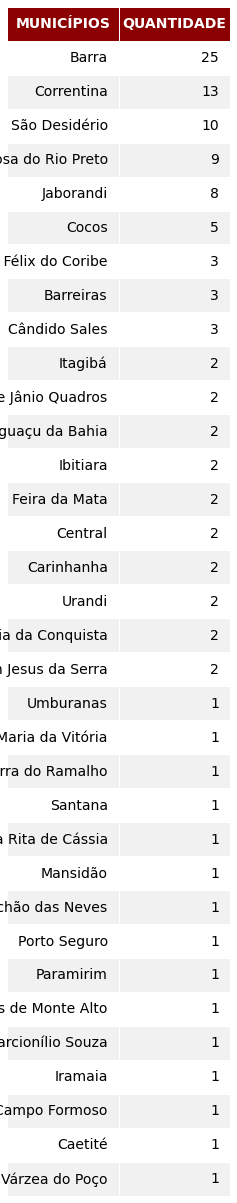

In [38]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#8B0000', row_colors=['#f1f1f2', 'w'], Edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(Edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

fig = render_mpl_table(tabela_aqua, header_columns=0, col_width=2.0)

plt.savefig('Y:/METEOROLOGIA/Boletins Meteorológicos/Boletim Diário de Focos de Calor/Dados_diarios/Satelite_referencia' + '_-_' + "AQUA" + date_corr + '.png')


In [ ]:
#requests for FIRMS - S-NPP_375
npp_link = 'https://nrt3.modaps.eosdis.nasa.gov/api/v2/content/archives/FIRMS/suomi-npp-viirs-c2/South_America/SUOMI_VIIRS_C2_South_America_VNP14IMGTDL_NRT_' + data_arquivo + '.txt'
#npp_link = 'https://nrt3.modaps.eosdis.nasa.gov/api/v2/content/archives/FIRMS/suomi-npp-viirs-c2/South_America/SUOMI_VIIRS_C2_South_America_VNP14IMGTDL_NRT_2021230.txt'

npp_rqt = requests.get(npp_link, headers=my_headers).content
data_npp = pd.read_csv(io.StringIO(npp_rqt.decode('utf-8')))

if requests.get(npp_link, headers=my_headers).status_code == 200:
  data_npp = gpd.GeoDataFrame(data_npp, geometry=gpd.points_from_xy(data_npp.longitude,data_npp.latitude, crs='EPSG:4674'))
  data_npp = gpd.overlay(data_npp, municipios, how='intersection')

  d = data_npp.acq_date + ' ' + data_npp.acq_time
  dt = [datetime.datetime.strptime(i, '%Y-%m-%d %H:%M') for i in list(d)]
  date_time = [int(time.mktime(i.timetuple())) for i in list(dt)]

  data_npp['date_time'] = date_time
  data_npp['data_hora'] = d

  npp = data_npp.drop(columns=['scan','track','confidence','version'])
  dict_dn = {'N':0,'D':1}
  dict_sat = {'N':'NPP'}
  npp['daynight'] = npp['daynight'].map(dict_dn)
  npp['satellite'] = npp['satellite'].map(dict_sat)
  npp = npp.rename(columns={'bright_ti4': 'bright_1','bright_ti5': 'bright_2'})

npp

,latitude,longitude,bright_1,acq_date,acq_time,satellite,bright_2,frp,daynight,municipios,territorio,regiao_cli,geometry,date_time,data_hora
0,-9.37957,-38.93982,322.14,2021-09-16,04:19,NPP,292.51,2.01,0,Macururé,ITAPARICA,Nordeste,POINT (-38.93982 -9.37957),1631765940,2021-09-16 04:19
1,-9.35314,-40.26580,319.14,2021-09-16,04:19,NPP,293.12,1.60,0,Juazeiro,SERTÃO DO SÃO FRANCISCO,Norte,POINT (-40.26580 -9.35314),1631765940,2021-09-16 04:19
2,-9.45242,-40.32528,338.62,2021-09-16,04:19,NPP,293.51,8.74,0,Juazeiro,SERTÃO DO SÃO FRANCISCO,Norte,POINT (-40.32528 -9.45242),1631765940,2021-09-16 04:19
3,-9.45649,-40.32589,351.73,2021-09-16,04:19,NPP,298.15,8.74,0,Juazeiro,SERTÃO DO SÃO FRANCISCO,Norte,POINT (-40.32589 -9.45649),1631765940,2021-09-16 04:19
4,-9.46950,-40.37948,305.01,2021-09-16,04:19,NPP,292.28,20.68,0,Juazeiro,SERTÃO DO SÃO FRANCISCO,Norte,POINT (-40.37948 -9.46950),1631765940,2021-09-16 04:19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2894,-15.31933,-39.80794,352.58,2021-09-16,16:56,NPP,302.80,8.30,1,Itaju do Colônia,LITORAL SUL,Sul,POINT (-39.80794 -15.31933),1631811360,2021-09-16 16:56
2895,-15.53603,-41.12873,367.00,2021-09-16,16:56,NPP,306.76,8.35,1,Encruzilhada,SUDOESTE BAIANO,Sudoeste,POINT (-41.12873 -15.53603),1631811360,2021-09-16 16:56
2896,-15.53714,-41.12948,367.00,2021-09-16,16:56,NPP,310.23,9.37,1,Encruzilhada,SUDOESTE BAIANO,Sudoeste,POINT (-41.12948 -15.53714),1631811360,2021-09-16 16:56
2897,-15.29710,-39.85551,354.31,2021-09-16,16:56,NPP,298.03,7.36,1,Itapetinga,MÉDIO SUDOESTE DA BAHIA,Sudoeste,POINT (-39.85551 -15.29710),1631811360,2021-09-16 16:56


In [ ]:
from google.colab import files
npp.to_csv('focos_NPP_15-09-2021.csv', encoding='UTF-8')
files.download("focos_NPP_15-09-2021.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
focos = gpd.GeoDataFrame(npp, geometry=gpd.points_from_xy(npp.longitude,npp.latitude, crs='EPSG:4674'))

In [ ]:
focos

,latitude,longitude,bright_ti4,acq_date,acq_time,satellite,bright_ti5,frp,daynight,date_time,geometry
0,-5.25614,-37.72008,308.16,2021-08-18,03:21,2,290.80,1.49,0,1629256860,POINT (-37.72008 -5.25614)
1,-3.59430,-38.85737,309.13,2021-08-18,03:21,2,291.81,1.75,0,1629256860,POINT (-38.85737 -3.59430)
2,-3.59374,-38.86065,340.68,2021-08-18,03:21,2,293.46,1.75,0,1629256860,POINT (-38.86065 -3.59374)
3,-3.59504,-38.86041,346.92,2021-08-18,03:21,2,293.67,5.00,0,1629256860,POINT (-38.86041 -3.59504)
4,-4.72286,-42.93050,339.39,2021-08-18,03:21,2,290.03,8.32,0,1629256860,POINT (-42.93050 -4.72286)
...,...,...,...,...,...,...,...,...,...,...,...
30143,-6.21337,-77.12424,328.13,2021-08-18,19:23,2,290.88,5.79,1,1629314580,POINT (-77.12424 -6.21337)
30144,0.56581,-78.20647,367.00,2021-08-18,19:25,2,290.97,12.24,1,1629314700,POINT (-78.20647 0.56581)
30145,0.56661,-78.20132,327.13,2021-08-18,19:25,2,287.85,12.24,1,1629314700,POINT (-78.20132 0.56661)
30146,0.61090,-78.13065,335.77,2021-08-18,19:25,2,270.46,7.67,1,1629314700,POINT (-78.13065 0.61090)


In [ ]:
fig = px.density_mapbox(focos, lat='latitude', lon='longitude', z='frp', radius=10,
                        center=dict(lat=-12.91,lon=-41.68), zoom=4.5,
                        mapbox_style="stamen-terrain")
fig.show()

In [ ]:
focos_2020 = municipios.to_crs("EPSG:4674")

In [ ]:
res_intersection = gpd.overlay(focos, municipios, how='intersection')

In [ ]:
res_intersection

,latitude,longitude,bright_ti4,acq_date,acq_time,satellite,bright_ti5,frp,daynight,date_time,Municipios,Codigo_IBG,Territorio,Area_Total,Regioes_Cl,geometry
0,-9.39949,-40.30604,300.48,2021-08-18,03:23,2,289.87,0.84,0,1629256980,Juazeiro,2918407,SERTÃO DO SÃO FRANCISCO,6901.0969,Norte,POINT (-40.30604 -9.39949)
1,-9.40010,-40.30276,323.36,2021-08-18,03:23,2,289.83,0.84,0,1629256980,Juazeiro,2918407,SERTÃO DO SÃO FRANCISCO,6901.0969,Norte,POINT (-40.30276 -9.40010)
2,-9.39481,-40.30178,307.08,2021-08-18,03:23,2,290.09,0.84,0,1629256980,Juazeiro,2918407,SERTÃO DO SÃO FRANCISCO,6901.0969,Norte,POINT (-40.30178 -9.39481)
3,-9.57778,-40.35654,302.04,2021-08-18,03:23,2,290.87,1.29,0,1629256980,Juazeiro,2918407,SERTÃO DO SÃO FRANCISCO,6901.0969,Norte,POINT (-40.35654 -9.57778)
4,-9.57840,-40.35323,313.35,2021-08-18,03:23,2,290.42,1.06,0,1629256980,Juazeiro,2918407,SERTÃO DO SÃO FRANCISCO,6901.0969,Norte,POINT (-40.35323 -9.57840)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,-9.65836,-43.40855,341.67,2021-08-18,16:01,2,305.22,4.38,1,1629302460,Pilão Arcado,2924405,SERTÃO DO SÃO FRANCISCO,11886.4306,São Francisco,POINT (-43.40855 -9.65836)
536,-9.65892,-43.41278,351.21,2021-08-18,16:01,2,308.26,11.36,1,1629302460,Pilão Arcado,2924405,SERTÃO DO SÃO FRANCISCO,11886.4306,São Francisco,POINT (-43.41278 -9.65892)
537,-9.65949,-43.41704,338.03,2021-08-18,16:01,2,306.24,11.36,1,1629302460,Pilão Arcado,2924405,SERTÃO DO SÃO FRANCISCO,11886.4306,São Francisco,POINT (-43.41704 -9.65949)
538,-9.65398,-43.40909,333.21,2021-08-18,16:01,2,303.49,4.38,1,1629302460,Pilão Arcado,2924405,SERTÃO DO SÃO FRANCISCO,11886.4306,São Francisco,POINT (-43.40909 -9.65398)


In [ ]:
fig = px.density_mapbox(res_intersection, lat='latitude', lon='longitude', radius=10,
                        center=dict(lat=-12.91,lon=-41.68), zoom=4.5,
                        mapbox_style="open-street-map", hover_name= res_intersection.Municipios)
fig.show()